In [70]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm


In [44]:

# Load the data
file_path = "dataset/agriculture_dataset.csv"
df = pd.read_csv(file_path)


In [62]:
# Define the function to handle missing values
def handle_missing_values(data, column, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy)
    data[[column]] = imputer.fit_transform(data[[column]])
    return data

# Define the function for IQR outlier detection
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[f'iqr_outlier'] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), -1, 1)
    return data

# Define the function for Z-Score outlier detection
def detect_outliers_zscore(data, column, threshold=3):
    data['zscore'] = (data[column] - data[column].mean()) / data[column].std()
    data[f'zscore_outlier'] = np.where(np.abs(data['zscore']) > threshold, -1, 1)
    data.drop(columns=['zscore'], inplace=True)
    return data

# Define the function for combined IQR and Z-Score outlier detection
# def detect_outliers_iqr_zscore(data, column):
#     data = detect_outliers_iqr(data, column)
#     data = detect_outliers_zscore(data, column)
#     data['iqr_zscore_outlier'] = np.where((data['iqr_outlier'] == -1) & (data['zscore_outlier'] == -1), -1, 1)
#     return data

# Define the function for Isolation Forest outlier detection
def detect_outliers_isolation_forest(data, column):
    iso_forest = IsolationForest(contamination=0.05)
    labels = iso_forest.fit_predict(data[[column]])
    data[f'if_outlier'] = np.where(labels == -1, -1, 1)
    return data

# Define the function for DBSCAN outlier detection
def detect_outliers_dbscan(data, column):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[[column]])
    dbscan = DBSCAN(eps=0.3, min_samples=10)
    labels = dbscan.fit_predict(scaled_data)
    data[f'dbscan_outlier'] = np.where(labels == -1, -1, 1)
    return data

# Define the function for One-Class SVM outlier detection
def detect_outliers_one_class_svm(data, column):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[[column]])
    svm = OneClassSVM(nu=0.05)
    labels = svm.fit_predict(scaled_data)
    data[f'ocsvm_outlier'] = np.where(labels == -1, -1, 1)
    return data

# Define the function for Local Outlier Factor (LOF) outlier detection
def detect_outliers_lof(data, column):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    labels = lof.fit_predict(data[[column]])
    data[f'lof_outlier'] = np.where(labels == -1, -1, 1)
    return data


# Define the function for Gaussian Naive Bayes outlier detection using the Gaussian PDF
def detect_outliers_gaussian(data, column, threshold=0.01):
    # Calculate the mean and standard deviation of the column
    mean = data[column].mean()
    std_dev = data[column].std()
    
    # Calculate the probability density for each point
    pdf_values = norm.pdf(data[column], mean, std_dev)
    
    # Label outliers as -1 if their probability density is below the threshold
    data[f'gaussian_outlier'] = np.where(pdf_values < threshold, -1, 1)
    
    return data

# HBOS (Histogram-based Outlier Score)
def detect_outliers_hbos(data, column):
    hbos = HBOS()
    hbos.fit(data[[column]])
    scores = hbos.decision_function(data[[column]])
    threshold = np.percentile(scores, 95)
    data[f'hbos_outlier'] = np.where(scores > threshold, -1, 1)
    return data

# CBLOF (Cluster-Based Local Outlier Factor)
def detect_outliers_cblof(data, column):
    cblof = CBLOF()
    cblof.fit(data[[column]])
    labels = cblof.predict(data[[column]])
    data[f'cblof_outlier'] = np.where(labels == 1, 1, -1)  # CBLOF marks outliers as 1
    return data

# Mahalanobis Distance
def detect_outliers_mahalanobis(data, column):
    mean = np.mean(data[column])
    cov = np.cov(data[column].T)
    inv_covmat = np.linalg.inv(cov)
    data['mahalanobis'] = data.apply(lambda row: Mahalanobis(row[column], mean, inv_covmat), axis=1)
    threshold = np.percentile(data['mahalanobis'], 95)
    data[f'mahalanobis_outlier'] = np.where(data['mahalanobis'] > threshold, -1, 1)
    data.drop(columns=['mahalanobis'], inplace=True)
    return data


In [63]:
# Function to handle missing values
def handle_missing_values(data, column, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy)
    data[[column]] = imputer.fit_transform(data[[column]])
    return data

# Function to detect outliers using a combination of Isolation Forest and Local Outlier Factor
def detect_outliers_if_lof(data, column):
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.05)
    if_labels = iso_forest.fit_predict(data[[column]])
    
    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    lof_labels = lof.fit_predict(data[[column]])
    
    # Combining results
    combined_labels = np.where((if_labels == -1) & (lof_labels == -1), -1, 1)
    data[f'if_lof_outlier'] = combined_labels
    return data

# Function to detect outliers using a combination of Isolation Forest, Gaussian PDF, and Local Outlier Factor
def detect_outliers_if_gaussian_lof(data, column):
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.05)
    if_labels = iso_forest.fit_predict(data[[column]])
    
    # Gaussian PDF
    mean = data[column].mean()
    std = data[column].std()
    gaussian_pdf = norm.pdf(data[column], mean, std)
    threshold = 0.01  # Assuming a threshold for the PDF
    gaussian_labels = np.where(gaussian_pdf < threshold, -1, 1)
    
    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    lof_labels = lof.fit_predict(data[[column]])
    
    # Combining results
    combined_labels = np.where((if_labels == -1) & (gaussian_labels == -1) & (lof_labels == -1), -1, 1)
    data[f'if_gaussian_lof_outlier'] = combined_labels
    return data

# Function to detect outliers using a combination of Isolation Forest, DBSCAN, and One-Class SVM
def detect_outliers_if_dbscan_svm(data, column):
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.05)
    if_labels = iso_forest.fit_predict(data[[column]])
    
    # DBSCAN
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[[column]].values.reshape(-1, 1))
    dbscan = DBSCAN(eps=0.3, min_samples=10)
    dbscan_labels = dbscan.fit_predict(scaled_data)
    dbscan_labels = np.where(dbscan_labels == -1, -1, 1)  # Convert DBSCAN labels to -1 and 1
    
    # One-Class SVM
    svm = OneClassSVM(nu=0.05)
    svm_labels = svm.fit_predict(scaled_data)
    
    # Combining results
    combined_labels = np.where((if_labels == -1) & (dbscan_labels == -1) & (svm_labels == -1), -1, 1)
    data[f'if_dbscan_svm_outlier'] = combined_labels
    return data

In [64]:
# Function to detect outliers using Gaussian Naive Bayes (GNB)
def detect_outliers_gnb(data, column, threshold=0.01):
    # Fit Gaussian Naive Bayes model
    gnb = GaussianNB()
    data_reshaped = data[[column]].values.reshape(-1, 1)
    
    # GNB requires labels for fitting; we'll use a dummy label array
    dummy_labels = np.zeros(data_reshaped.shape[0])
    
    # Fit the model (ignoring the labels)
    gnb.fit(data_reshaped, dummy_labels)
    
    # Calculate probabilities
    probabilities = gnb.predict_proba(data_reshaped)[:, 0]  # probability of the only class
    
    # Detect outliers based on the threshold
    outliers = probabilities < threshold
    data[f'GNB_outlier'] = np.where(outliers, -1, 1)
    return data

In [65]:

# Apply the missing value handler
data = handle_missing_values(df, 'N2O', strategy='mean')


In [66]:

# Apply each outlier detection method
data = detect_outliers_iqr(data, 'N2O')
data = detect_outliers_zscore(data, 'N2O')
data = detect_outliers_iqr_zscore(data, 'N2O')
data = detect_outliers_isolation_forest(data, 'N2O')
data = detect_outliers_dbscan(data, 'N2O')
data = detect_outliers_one_class_svm(data, 'N2O')
data = detect_outliers_lof(data, 'N2O')
data = detect_outliers_gaussian(data, 'N2O')
# data = detect_outliers_hbos(data, 'N2O')
# data = detect_outliers_cblof(data, 'N2O')
# data = detect_outliers_mahalanobis(data, 'N2O')
# data = detect_outliers_kmeans(data, 'N2O')
# data = detect_outliers_knn(data, 'N2O')


In [67]:
# Apply combined outlier detection methods
data = detect_outliers_if_lof(data, 'N2O')
data = detect_outliers_if_gaussian_lof(data, 'N2O')
data = detect_outliers_if_dbscan_svm(data, 'N2O')


In [58]:
data = detect_outliers_gnb(data, 'N2O')

In [68]:
data

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,if_outlier,dbscan_outlier,ocsvm_outlier,lof_outlier,nb_outlier,if_lof_outlier,if_gaussian_lof_outlier,if_dbscan_svm_outlier,GNB_outlier,gaussian_outlier
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,1,1,1,1,1,1,1,1,1,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,1,1,1,1,1,1,1,1,1,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,1,1,1,1,1,1,1,1,1,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,1,1,1,1,1,1,1,1,1,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,1,1,1,1,1,1,1,1,1,1
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,1,1,1,1,1,1,1,1,1,1
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,1,1,1,1,1,1,1,1,1,1
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,1,1,1,1,1,1,1,1,1,1


In [ ]:

# Display the updated data with outlier column
# data = detect_outliers_hbos(data, 'N2O')
# data = detect_outliers_cblof(data, 'N2O')
# data = detect_outliers_mahalanobis(data, 'N2O')


In [69]:
data.to_csv('hasil/0905_1_N2O_Agriculture_OutlierDetection_4_Update09062024.csv', index=False)

In [ ]:
data

In [60]:
# Summarize the count of outliers and inliers for each method

def summarize_outliers(df, method_columns):
    summary = []
    for column in method_columns:
        inliers = df[column].value_counts().get(1, 0)
        outliers = df[column].value_counts().get(-1, 0) if df[column].min() == -1 else df[column].value_counts().get(0, 0)
        total = len(df[column])
        summary.append({
            'Method': column.replace('_outlier', ''),
            'Outliers': outliers,
            'Inliers': inliers,
            'Total': total
        })
    return pd.DataFrame(summary)

# List of outlier detection columns
outlier_columns = [col for col in df.columns if col.endswith('_outlier')]

# Generate the summary
summary_df = summarize_outliers(df, outlier_columns)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Outlier Detection Summary", dataframe=summary_df)

summary_df


,Method,Outliers,Inliers,Total
0,iqr,251,1995,2246
1,zscore,32,2214,2246
2,iqr_zscore,32,2214,2246
3,if,113,2133,2246
4,dbscan,37,2209,2246
5,ocsvm,112,2134,2246
6,lof,113,2133,2246
7,nb,87,2159,2246
8,if_lof,40,2206,2246
9,if_gaussian_lof,28,2218,2246


In [55]:
# Define a function to summarize the count of inliers and outliers for each method
def summarize_outliers(data, methods):
    summary = []
    for method in methods:
        inliers = (data[f'{method}_outlier'] == 1).sum()
        outliers = (data[f'{method}_outlier'] == -1).sum()
        total = inliers + outliers
        summary.append({'Method': method, 'Inliers': inliers, 'Outliers': outliers, 'Total': total})
    return pd.DataFrame(summary)

# List of methods used for outlier detection
methods = ['iqr', 'zscore','iqr_zscore', 'if', 'dbscan', 'ocsvm', 'lof','nb','if_lof','if_gaussian_lof','if_dbscan_svm']

# Generate the summary
summary_df = summarize_outliers(data, methods)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Outlier Detection Summary", dataframe=summary_df)

summary_df


,Method,Inliers,Outliers,Total
0,iqr,1995,251,2246
1,zscore,2214,32,2246
2,iqr_zscore,2214,32,2246
3,if,2133,113,2246
4,dbscan,2209,37,2246
5,ocsvm,2134,112,2246
6,lof,2133,113,2246
7,nb,2159,87,2246
8,if_lof,2206,40,2246
9,if_gaussian_lof,2218,28,2246


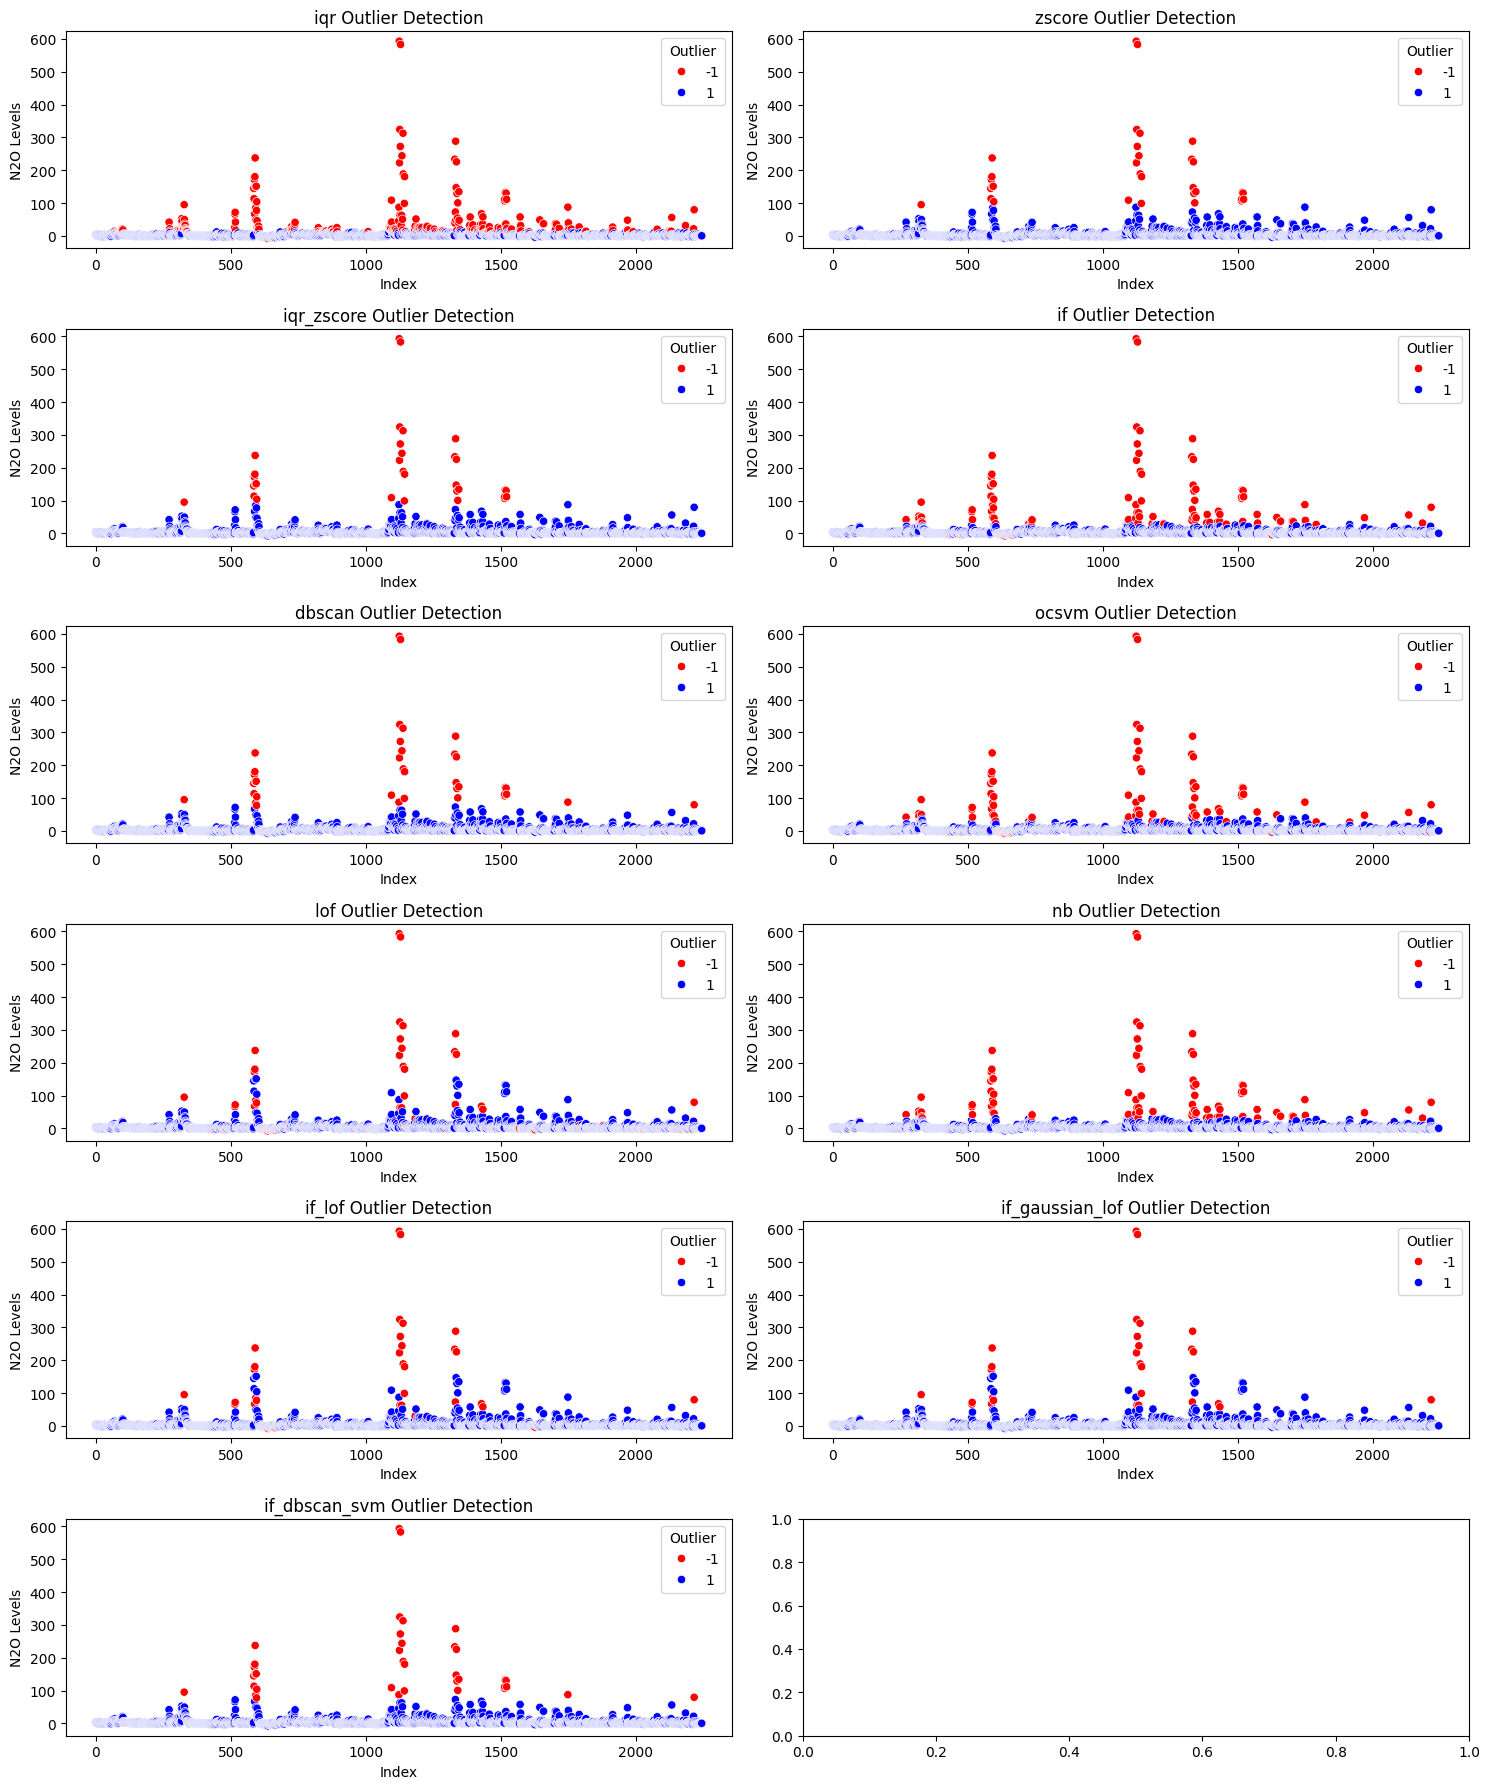

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure layout
fig, axes = plt.subplots(6, 2, figsize=(15, 18))

# List of methods for outlier detection
# methods = ['IQR', 'ZScore', 'IQR_ZScore', 'IF', 'DBSCAN', 'OneClassSVM', 'LOF', 'NaiveBayes']
# methods = ['IQR', 'ZScore','IQR_ZScore', 'IF', 'DBSCAN', 'OneClassSVM', 'LOF','NaiveBayes','IF_LOF','IF_Gaussian_LOF','IF_DBSCAN_SVM']
methods = ['iqr', 'zscore','iqr_zscore', 'if', 'dbscan', 'ocsvm', 'lof','nb','if_lof','if_gaussian_lof','if_dbscan_svm']

# Define a function to plot outliers for each method
def plot_outliers(data, method, ax):
    sns.scatterplot(x=data.index, y=data['N2O'], hue=data[f'{method}_outlier'], palette={1: 'blue', -1: 'red'}, ax=ax)
    ax.set_title(f'{method} Outlier Detection')
    ax.set_xlabel('Index')
    ax.set_ylabel('N2O Levels')
    ax.legend(title='Outlier', loc='upper right')

# Create a plot for each method
for i, method in enumerate(methods[:12]):
    plot_outliers(data, method, axes[i // 2, i % 2])

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


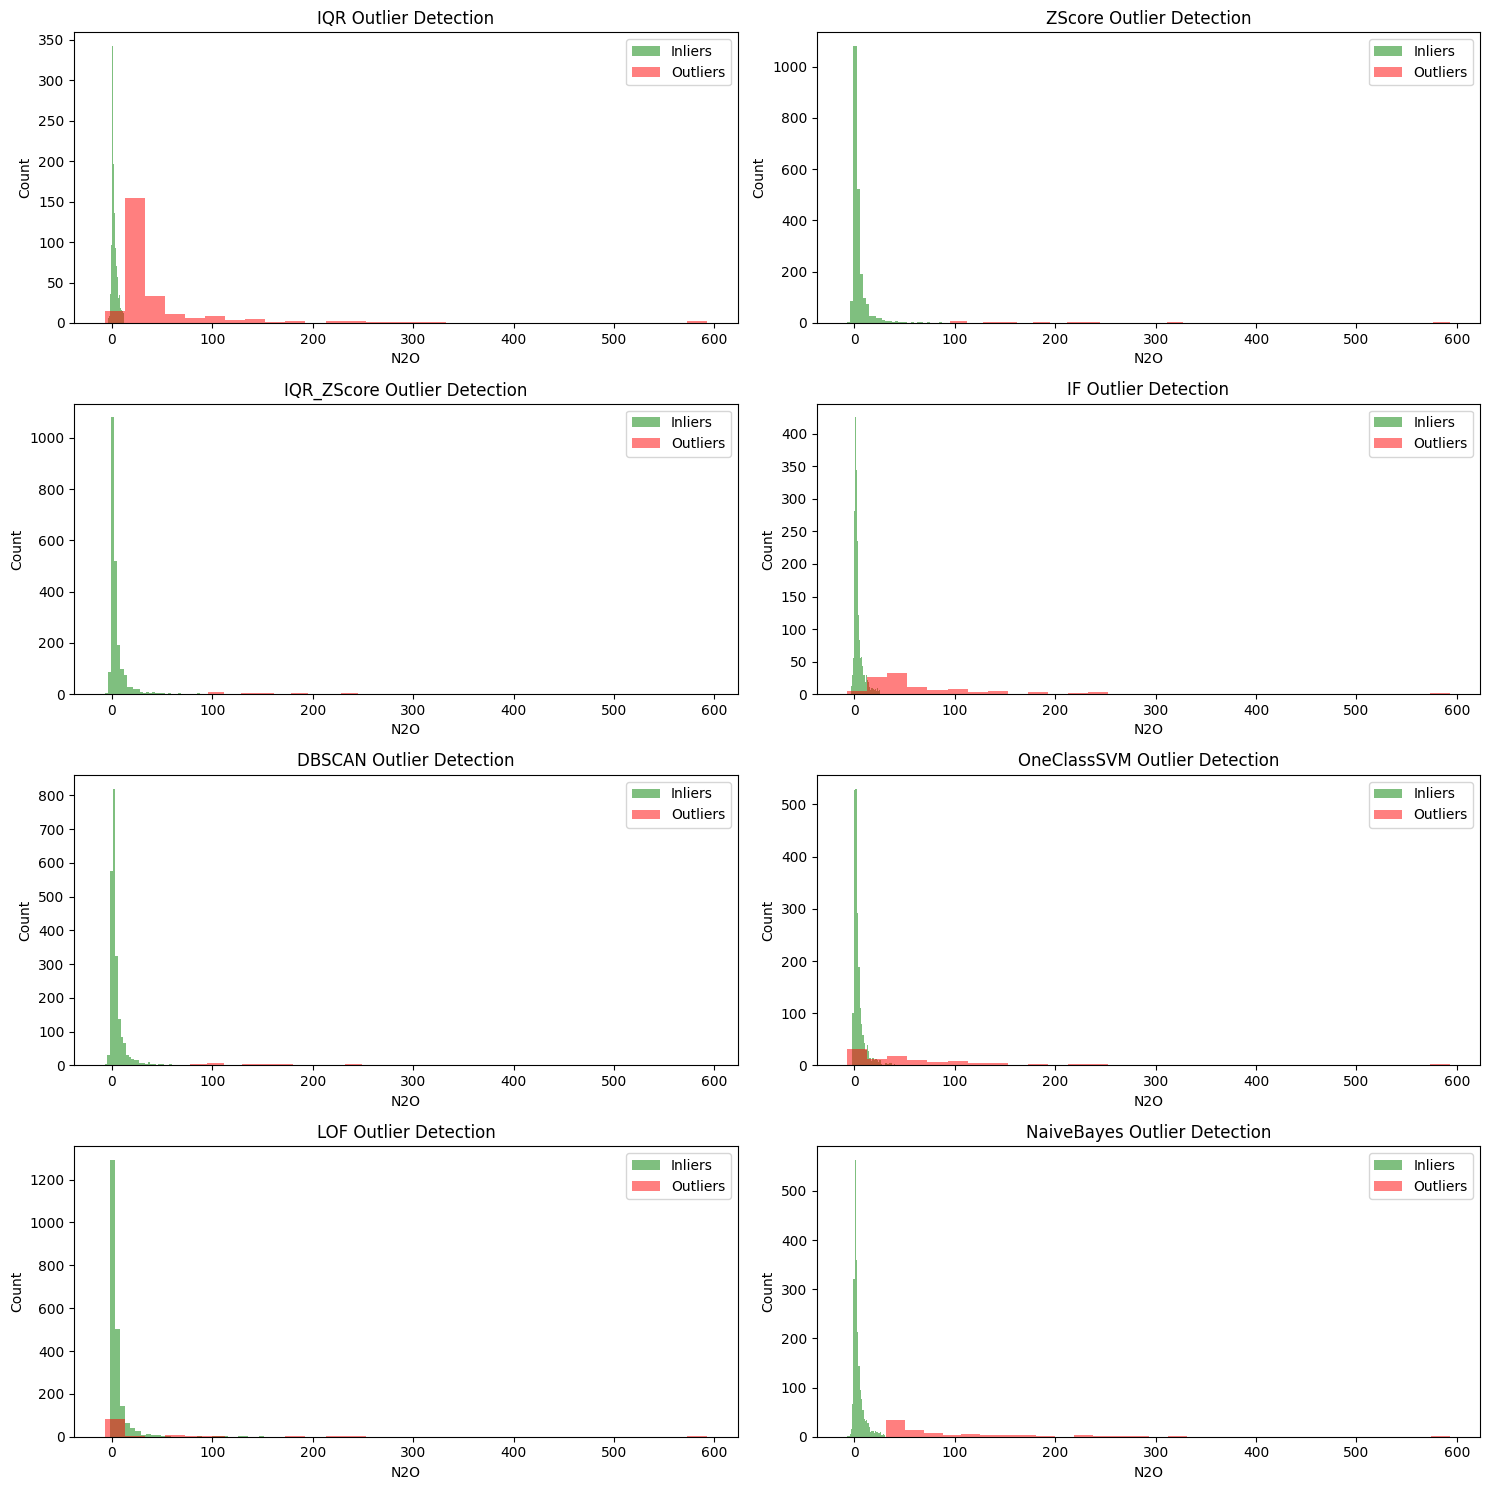

In [30]:
# Redefine the plotting code to handle the correct number of subplots (3 rows x 2 columns for 6 methods)
# Removing one of the methods from the plotting to fit the layout or handle separately

# List of methods used for outlier detection (reduced to 6 for fitting 3x2 layout)
# methods = ['IQR', 'ZScore', 'IQR_ZScore', 'IF', 'DBSCAN', 'OneClassSVM', 'LOF','NaiveBayes']
# List of methods used for outlier detection (reduced to 6 for fitting 3x2 layout)
methods_to_plot = ['IQR', 'ZScore', 'IQR_ZScore', 'IF', 'DBSCAN', 'OneClassSVM','LOF','NaiveBayes']

# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each method
for i, method in enumerate(methods_to_plot):
    ax = axes[i]
    inliers = data[data[f'{method}_outlier'] == 1]['N2O']
    outliers = data[data[f'{method}_outlier'] == -1]['N2O']
    
    ax.hist(inliers, bins=30, alpha=0.5, label='Inliers', color='green')
    ax.hist(outliers, bins=30, alpha=0.5, label='Outliers', color='red')
    ax.set_title(f'{method} Outlier Detection')
    ax.set_xlabel('N2O')
    ax.set_ylabel('Count')
    ax.legend()

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plots
plt.show()


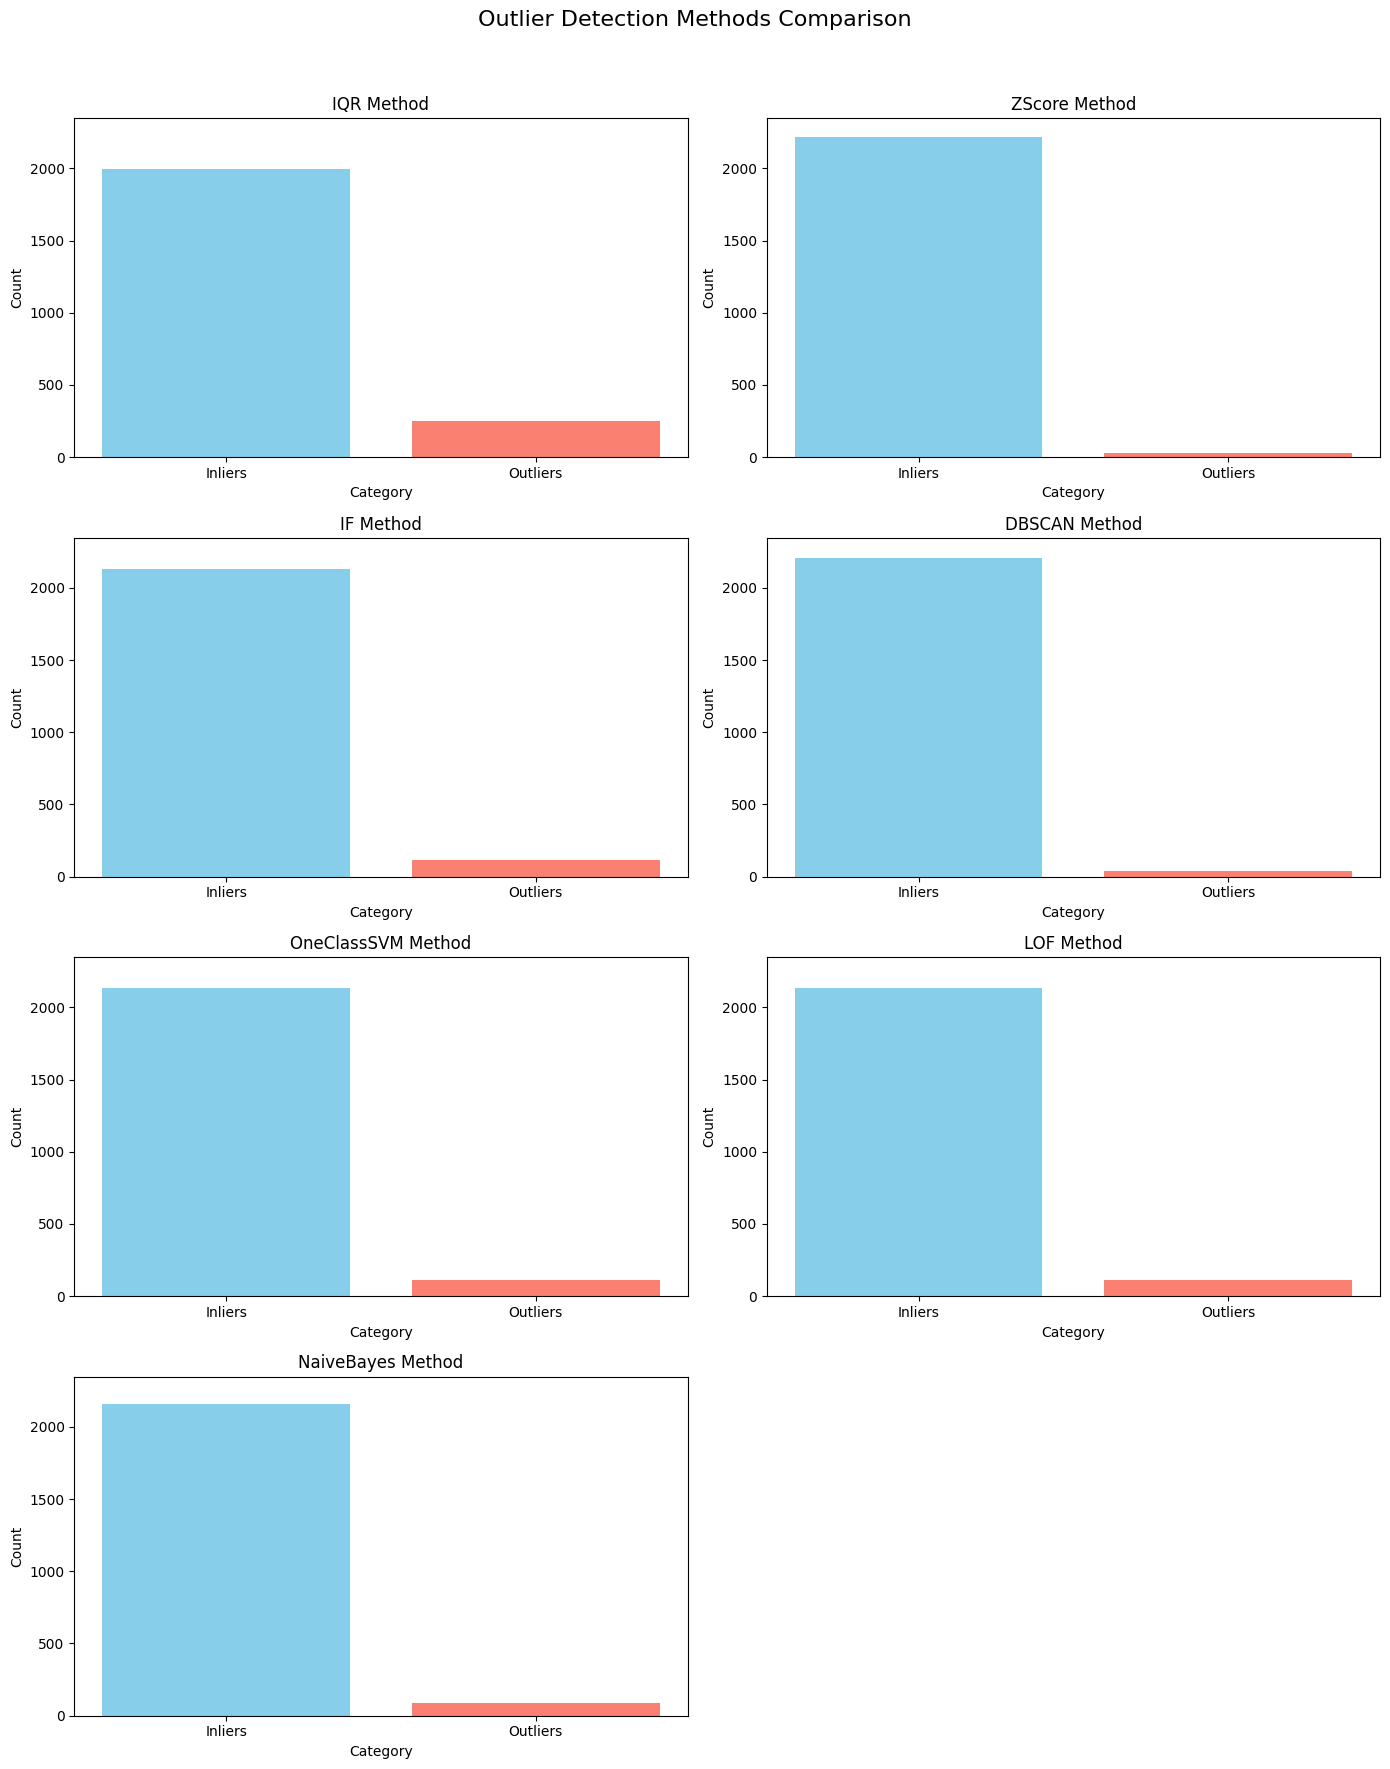

In [22]:
# To ensure proper indexing, we'll adjust the loop to match the correct number of subplots and handle exceptions.

def plot_outlier_comparison_final(summary_df):
    fig, axes = plt.subplots(4, 2, figsize=(14, 18))
    fig.suptitle('Outlier Detection Methods Comparison', fontsize=16)
    axes = axes.flatten()
    methods = summary_df['Method']

    # Plot each method
    for i, method in enumerate(methods):
        if i < len(axes):  # Ensure we don't access out-of-bound indexes
            axes[i].bar(['Inliers', 'Outliers'], summary_df.loc[i, ['Inliers', 'Outliers']], color=['skyblue', 'salmon'])
            axes[i].set_title(f'{method} Method')
            axes[i].set_xlabel('Category')
            axes[i].set_ylabel('Count')
            axes[i].set_ylim(0, summary_df['Total'].max() + 100)

    # Hide any unused subplots
    for j in range(len(methods), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize the comparison with the final corrected version
plot_outlier_comparison_final(summary_df)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6684\2019637573.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6684\2019637573.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6684\2019637573.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6684\2019637573.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

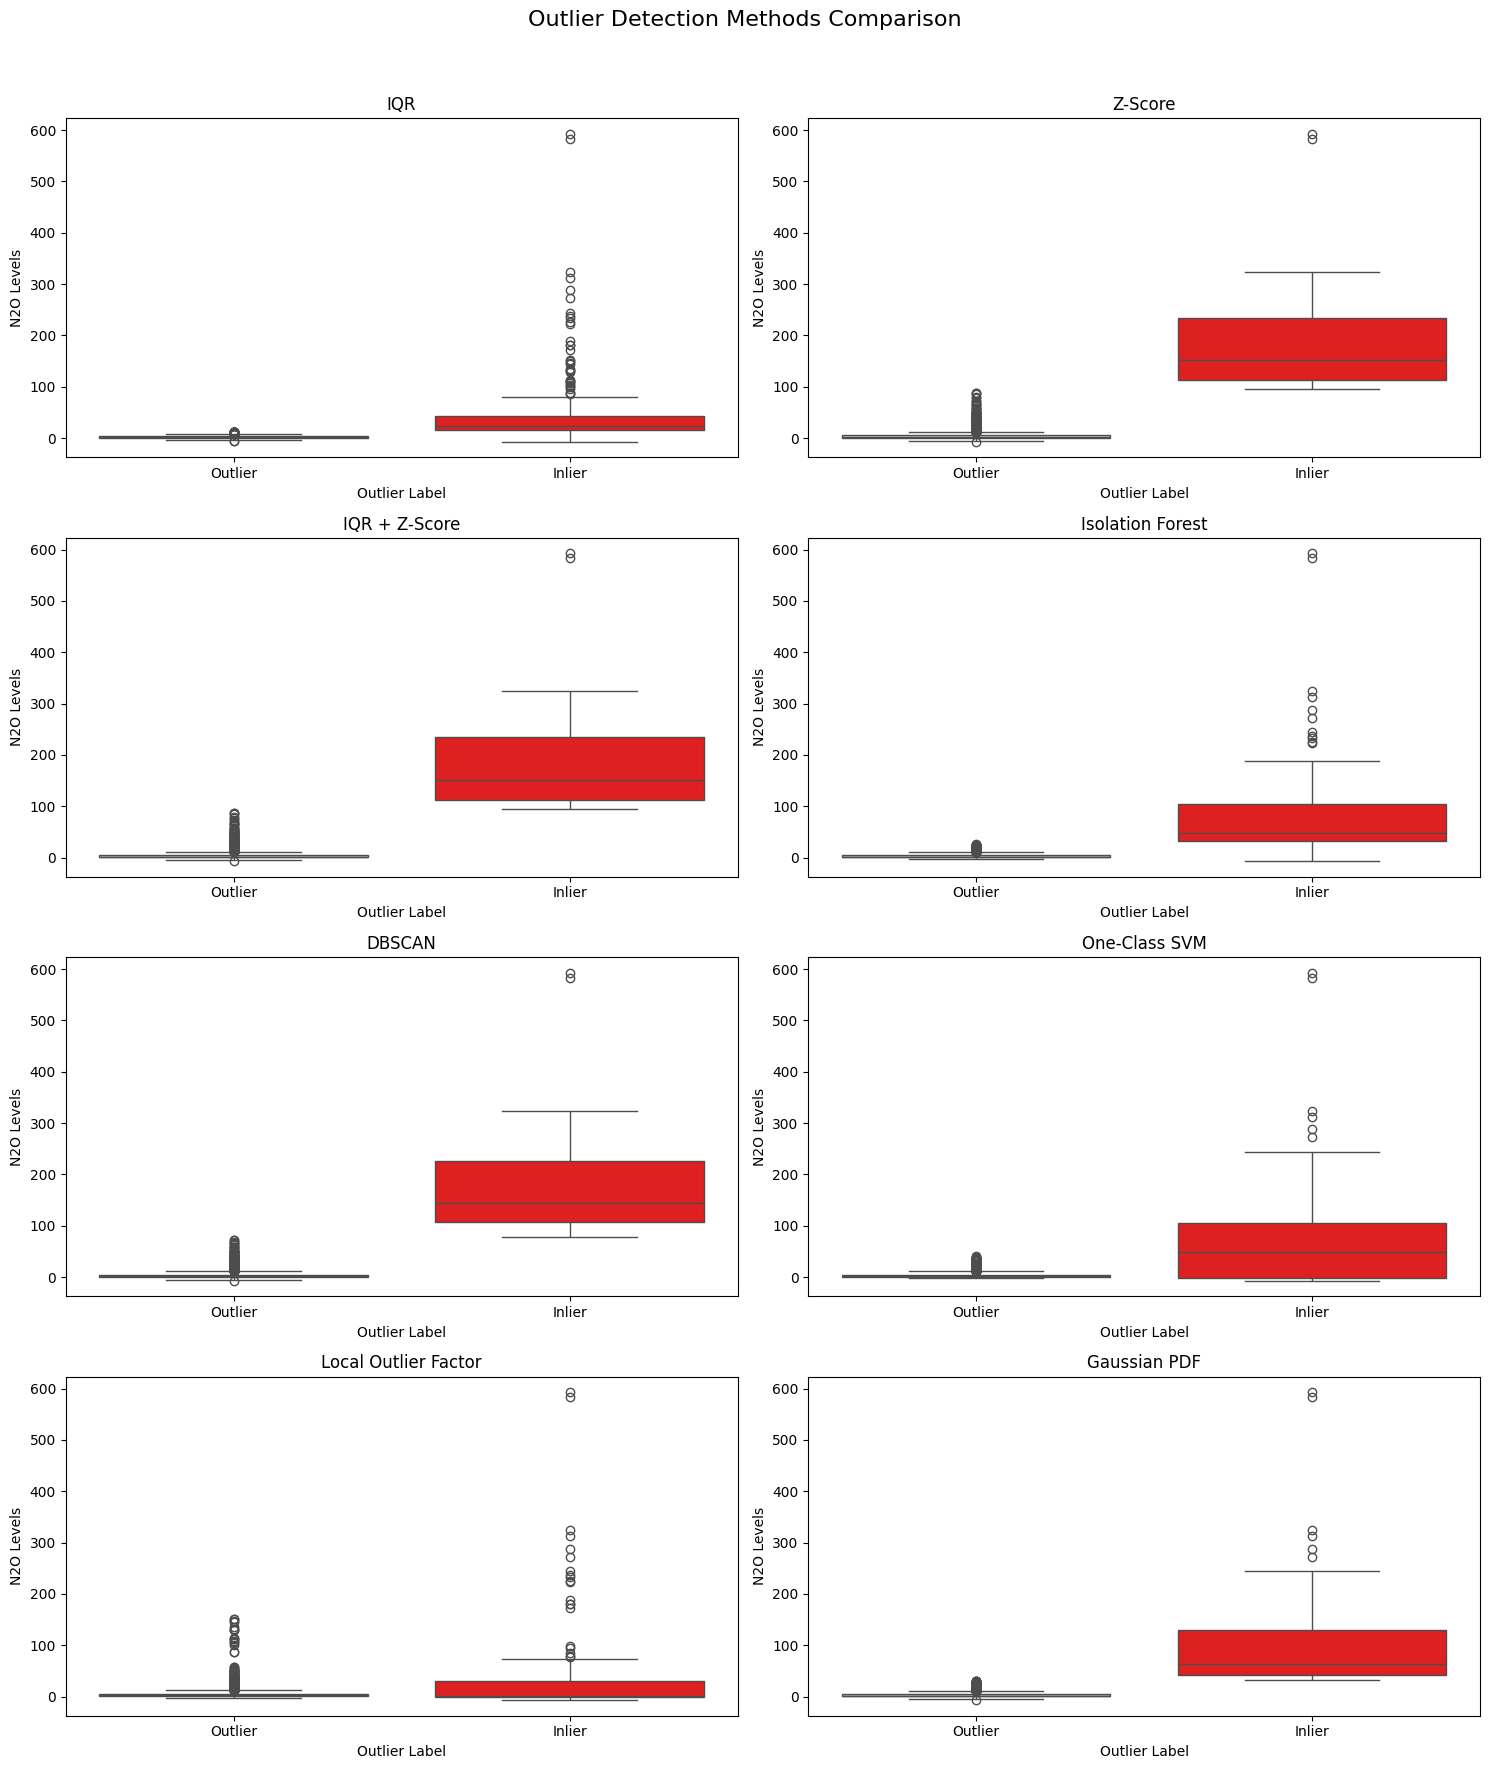

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the layout for the subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 18))
fig.suptitle('Outlier Detection Methods Comparison', fontsize=16)

# Flatten axes for easier indexing
axes = axes.flatten()

# Method list and their corresponding titles for the plots
methods = ['IQR', 'ZScore', 'IQR_ZScore', 'IF', 'DBSCAN', 'OneClassSVM', 'LOF','NaiveBayes']
titles = ['IQR', 'Z-Score', 'IQR + Z-Score', 'Isolation Forest', 'DBSCAN', 'One-Class SVM', 'Local Outlier Factor','Gaussian PDF']

# Generate boxplots for each method
for i, method in enumerate(methods):
    if i < len(axes):
        sns.boxplot(
            x=data[f'{method}_outlier'].astype(str),  # Convert labels to strings for the palette
            y=data['N2O'], 
            ax=axes[i], 
            palette={'1': 'lightblue', '-1': 'red'}
        )
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Outlier Label')
        axes[i].set_ylabel('N2O Levels')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Outlier', 'Inlier'])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


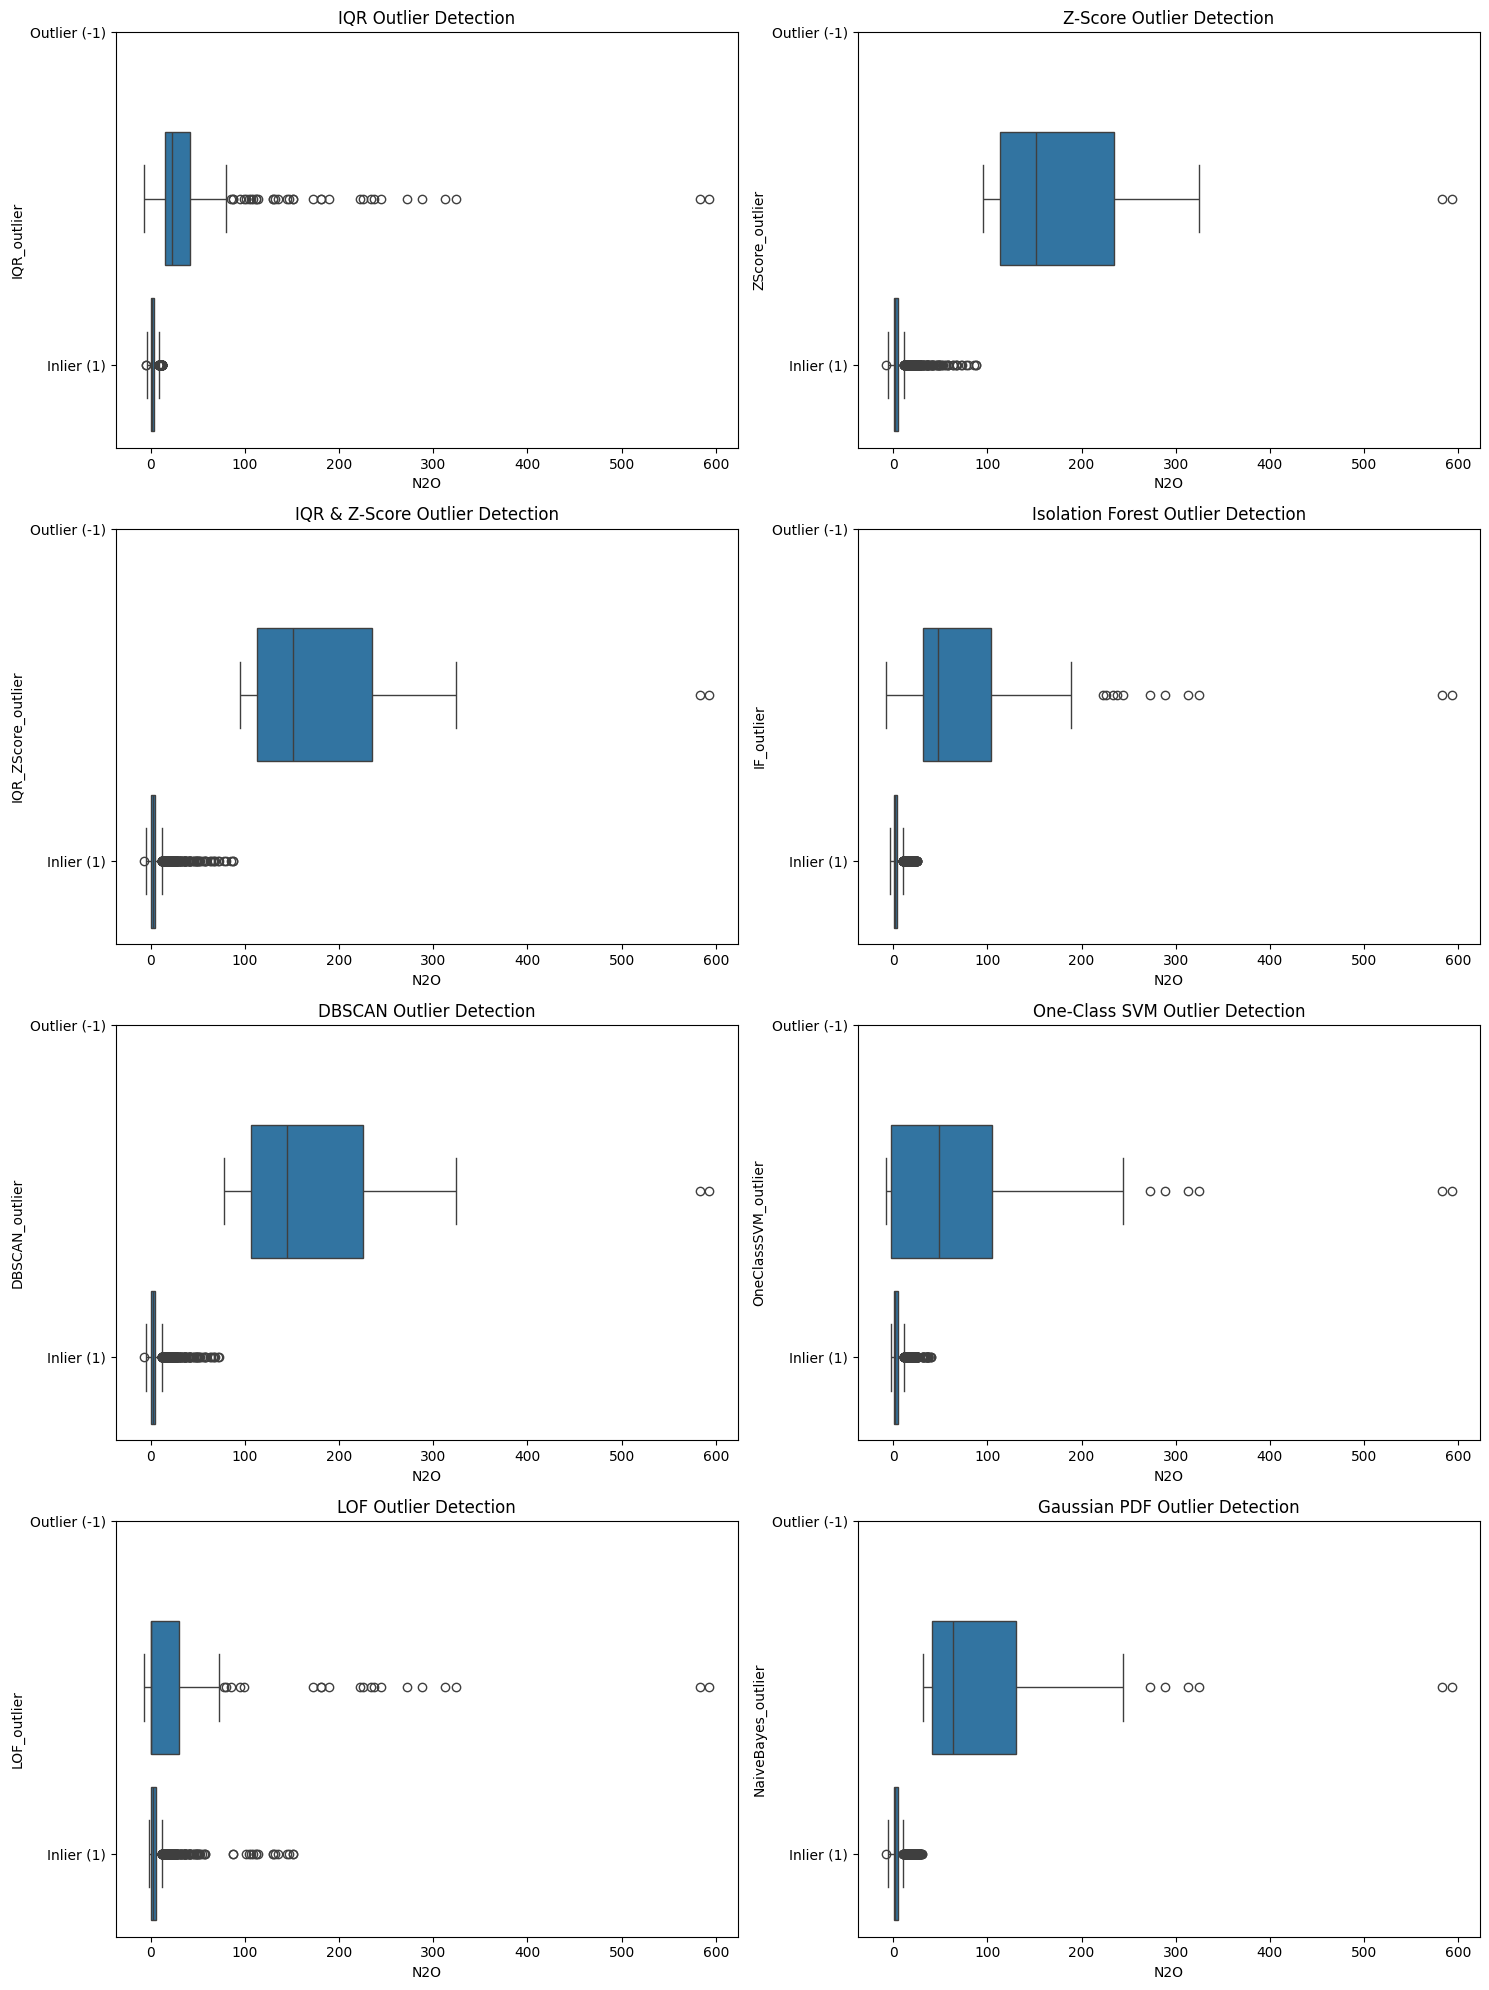

In [25]:
# Adjust the layout for 4 rows and 2 columns to accommodate all methods
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# List of methods and corresponding names for visualization
methods_for_viz = ['IQR', 'ZScore', 'IQR_ZScore', 'IF', 'DBSCAN', 'OneClassSVM', 'LOF','NaiveBayes']
method_names = ['IQR', 'Z-Score', 'IQR & Z-Score', 'Isolation Forest', 'DBSCAN', 'One-Class SVM', 'LOF','Gaussian PDF']

# Plot each method's outliers
for i, method in enumerate(methods_for_viz):
    row = i // 2
    col = i % 2
    sns.boxplot(x='N2O', y=f'{method}_outlier', data=data, ax=axes[row, col], orient='h')
    axes[row, col].set_title(f'{method_names[i]} Outlier Detection')
    axes[row, col].set_yticks([-1, 1])
    axes[row, col].set_yticklabels(['Outlier (-1)', 'Inlier (1)'])
    for tick in axes[row, col].get_yticklabels():
        tick.set_rotation(0)

# Hide the unused subplot if the number of methods is odd
if len(methods_for_viz) % 2 != 0:
    fig.delaxes(axes[3, 1])

plt.tight_layout()
plt.show()
